In [1]:
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob


from tqdm import tqdm

from utils import visualize, plot_data
from scipy.io import loadmat


SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/home/heye0507/drone/drone_benchmark/data/benchmark'
train_images = path + '/images'
test_images = path + '/test_images'
anno = path + '/annotation'
density_maps = path + '/dmaps'

In [3]:
def get_valid_trainsforms():
    return A.Compose(
        [
            #A.Resize(360,640,interpolation=2),
            A.Normalize(mean=mean,std=std,p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ]
    )

mean = torch.tensor([0.4939, 0.4794, 0.4583])
std = torch.tensor([0.2177, 0.2134, 0.2144])

def denormalize(img):
    img = img * std[...,None,None] + mean[...,None,None]
    img = img.permute(1,2,0).cpu().numpy()
    return img

In [4]:
class Counting_Dataset(Dataset):
    def __init__(self,path,image_fnames,dmap_folder,gt_folder=None,transforms=None,mosaic=False,downsample=4):
        '''
            path: root path 
            image_fnames: path of images
            dmap_folder: density map folder, eg: /dmap
            gt_folder: gt folder, currently set to visdrone xml format, modify _get_gt_data() if needed
            transforms: iteratable, can be tuple / list ... etc
            mosaic: mix up image and density map to form a new image, set to false by default
            downsample: resize dmap
        '''
        super().__init__()
        self.path = path
        self.image_fnames = image_fnames
        self.dmap_folder = path + dmap_folder
        self.transforms = transforms
        self.mosaic = mosaic
        self.downsample = downsample
        self.gt_folder = gt_folder # test purpose
        
    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self,idx):
        image_id = self.image_fnames[idx]
        
        if self.mosaic and random.randint(0,1) < 0.5:
            image, density_map, gt_points = self._load_mosaic_image_and_density_map(idx)
        else:
            image, density_map, gt_points = self._load_image_and_density_map(idx)
        
        h,w = image.shape[0]//self.downsample, image.shape[1]//self.downsample
        image = cv2.resize(image,(w, h))
        density_map = cv2.resize(density_map,(w//(self.downsample*2),h//(self.downsample*2)))#,interpolation=cv2.INTER_NEAREST)
        
        # Warning: doesn't work for cutout, uncommet transform and make fix code to enable cutout
        # Reason: cutout doesn't apply to mask, so mask must be image. check 01a bottom for code
        if self.transforms:
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': image,
                    'mask': density_map,
                    #'keypoints': gt_points
                })
                #image, density_map, gt_points = aug['image'], aug['mask'], aug['keypoints']
                image, density_map = aug['image'], aug['mask'] # issue with previous keypoints (albumentation?)
        
        
        return image, density_map, image_id, gt_points
        
    
    def _get_dmap_name(self,fn):
        mask_name = fn.split('/')[-1].split('.')[0]
        mask_path = self.dmap_folder + '/' + mask_name + '.npy'
        return mask_path
    
    def _load_image_and_density_map(self,idx):
        image_fname = self.image_fnames[idx]
        dmap_fname = self._get_dmap_name(image_fname)
        image = cv2.imread(image_fname)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.
        d_map = np.load(dmap_fname,allow_pickle=True)
        
        #sanity check gt
        _, points = self._get_gt_data(idx)
        # end sanity check
        
        return image, d_map, points
    
    def _load_mosaic_image_and_density_map(self,idx):
        image_1, dmap_1, points_1 = self._load_image_and_density_map(idx)
        while True:
            idx_2 = random.randint(0,len(self.image_fnames)-1)
            if idx != idx_2:
                break
        image_2, dmap_2, points_2 = self._load_image_and_density_map(idx_2)
        
        imsize = min(*image_1.shape[:2])
        xc,yc = [int(random.uniform(imsize*0.4,imsize*0.6)) for _ in range(2)]
        h,w = image_1.shape[0], image_1.shape[1]

        pos = random.randint(0,1)
        if pos == 0: #top left
            x1a,y1a,x2a,y2a = 0,0,xc,yc # img_1
            x1b,y1b,x2b,y2b = w-xc,h-yc,w,h # img_2
        elif pos == 1: # top right
            x1a,y1a,x2a,y2a = w-xc,0,w,yc
            x1b,y1b,x2b,y2b = 0,h-yc,xc,h
        elif pos == 2: # bottom left
            x1a,y1a,x2a,y2a = 0,h-yc,xc,h
            x1b,y1b,x2b,y2b = w-xc,0,w,yc
        elif pos == 3: # bottom right
            x1a,y1a,x2a,y2a = w-xc,h-yc,w,h
            x1b,y1b,x2b,y2b = 0,0,xc,yc
        
        new_image = image_1.copy()
        new_dmap = dmap_1.copy()
        new_image[y1a:y2a,x1a:x2a] = image_2[y1b:y2b,x1b:x2b]
        new_dmap[y1a:y2a,x1a:x2a] = dmap_2[y1b:y2b,x1b:x2b]
        
        #TODO: sanity check to see generate gt
        
        new_gt_points = self._get_mixed_gt_points(points_1,points_2,(x1a,y1a,x2a,y2a),(x1b,y1b,x2b,y2b),(h,w))
        
        return new_image, new_dmap, new_gt_points
    
    '''
    The follow section blocks are for sanity check 
    to compare dmap.sum() with gt points
    remove if needed
    '''
    def _get_mixed_gt_points(self,points_1,points_2,img_1_loc, img_2_loc,img_shape):
#         fn_1, points_1 = self._get_gt_data(idx_1)
#         fn_2, points_2 = self._get_gt_data(idx_2)
        x1a,y1a,x2a,y2a = img_1_loc
        x1b,y1b,x2b,y2b = img_2_loc
        h,w = img_shape
        
        result_boxes = []
        result_boxes.append(points_2)
        result_boxes = np.concatenate(result_boxes,0)
        padw = x1a-x1b
        pady = y1a-y1b

        result_boxes[:,0] += padw
        result_boxes[:,1] += pady

        np.clip(result_boxes[:,0],0,w,out=result_boxes[:,0])
        np.clip(result_boxes[:,1],0,h,out=result_boxes[:,1])
        result_boxes = result_boxes.astype(np.int32)

        result_boxes = result_boxes[np.where(result_boxes[:,0] * result_boxes[:,1] > 0)]
        result_boxes = result_boxes[np.where(result_boxes[:,0] < w)]
        result_boxes = result_boxes[np.where(result_boxes[:,1] < h)]
        
        boxes = []
        for (x,y) in points_1:
            if x >= x1a and x <= x2a and y >= y1a and y <= y2a:
                continue
            else:
                boxes.append((x,y))
        if len(boxes) == 0:
            return result_boxes
        return np.concatenate((boxes, result_boxes),axis=0)
    
    def _get_gt_data(self,idx):
        if not self.gt_folder:
            return (None,0)
        fn = self.image_fnames[idx]
        anno_path = self.path + self.gt_folder + '/' + fn.split('/')[-1].split('.')[0] + '.mat'
        test_data = loadmat(anno_path)
        points = test_data['annotation'].astype(int)
        return fn, points

In [5]:
class Crop_Dataset(Counting_Dataset):
    def __init__(self,path,image_fnames,dmap_folder,gt_folder=None,transforms=None,mosaic=False,downsample=4,crop_size=512,method='train'):
        super().__init__(path,image_fnames,dmap_folder,gt_folder,transforms,mosaic,downsample)
        self.crop_size = crop_size
        if method not in ['train','valid']:
            raise Exception('Not Implement')
        self.method = method
    
    def __getitem__(self,idx):
        fn = self.image_fnames[idx]
        
        image,density_map,gt_points = self._load_image_and_density_map(idx)
        h,w = image.shape[0], image.shape[1]
        #image = cv2.resize(image,(w, h))
        
        
        if self.method == 'train':
            #h,w = image.shape[:2]
            i,j = self._random_crop(h,w,self.crop_size,self.crop_size)
            image = image[i:i+self.crop_size,j:j+self.crop_size]
            density_map = density_map[i:i+self.crop_size,j:j+self.crop_size]
            
            gt_points = gt_points - [j,i]
            mask = (gt_points[:,0] >=0 ) * (gt_points[:,0] <= self.crop_size) * (gt_points[:,1]>=0) * (gt_points[:,1]<=self.crop_size)
            gt_points = gt_points[mask]
            density_map = cv2.resize(density_map,(self.crop_size//self.downsample,self.crop_size//self.downsample))
            
        else:
            density_map = cv2.resize(density_map,(w//self.downsample,h//self.downsample))#,interpolation=cv2.INTER_NEAREST)
        
        if self.transforms:
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': image,
                    'mask': density_map,
                    #'keypoints': gt_points
                })
                #image, density_map, gt_points = aug['image'], aug['mask'], aug['keypoints']
                image, density_map = aug['image'], aug['mask'] # issue with previous keypoints (albumentation?)
        return image, density_map, fn, gt_points
    
    def _random_crop(self, im_h, im_w, crop_h, crop_w):
        res_h = im_h - crop_h
        res_w = im_w - crop_w
        i = random.randint(0, res_h)
        j = random.randint(0, res_w)
        return i, j

In [6]:
test_fp = glob(test_images + '/*.jpg')

In [7]:
valid_dataset = Counting_Dataset(path=path,
                                 image_fnames=test_fp,dmap_folder='/dmaps',
                                 gt_folder='/annotation/all',
                                 transforms=[get_valid_trainsforms()],
                                 downsample=2,
                             #method='valid',
                                )

In [8]:
img, dmap, fn, points = valid_dataset[250]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4367)


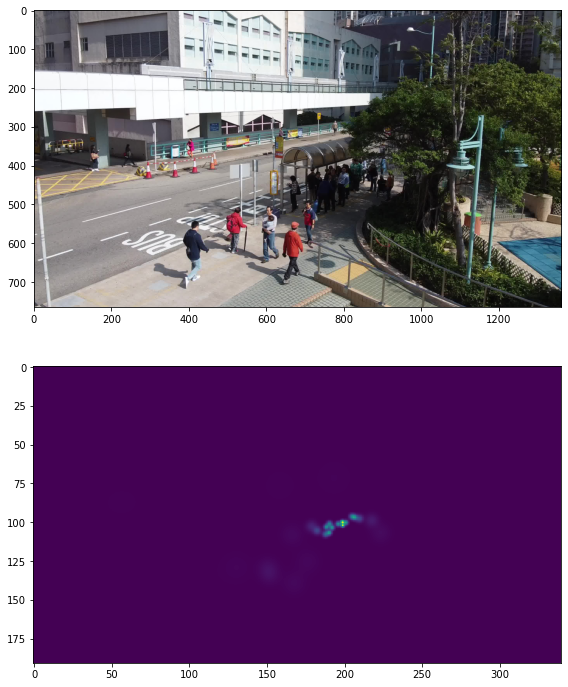

In [9]:
visualize(denormalize(img),dmap)

In [11]:
len(points), dmap.sum() * 8 * 8

(28, tensor(27.9519))

In [8]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 4
    n_epochs = 30 
    lr = 0.0002

    folder = 'mcnn_baseline'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=1e-3,
#         #total_steps = len(train_dataset) // 4 * n_epochs, # gradient accumulation
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.3,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )

In [9]:
def collate_fn(batch):
    imgs, dmaps, fns, gt_points = zip(*batch)
    imgs = torch.stack(imgs)
    dmaps = torch.stack(dmaps).unsqueeze(1)
    return imgs,dmaps,fns,gt_points

# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=TrainGlobalConfig.batch_size,
#     sampler=RandomSampler(train_dataset),
#     pin_memory=False,
#     drop_last=True,
#     num_workers=TrainGlobalConfig.num_workers,
#     collate_fn=collate_fn,
# )

val_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=TrainGlobalConfig.batch_size,
    num_workers=TrainGlobalConfig.num_workers,
    shuffle=False,
    sampler=SequentialSampler(valid_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)

In [10]:
'''
    credit: https://github.com/CommissarMa/MCNN-pytorch/blob/master/mcnn_model.py
'''

class MCNN(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self,load_weights=False):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))

        if not load_weights:
            self._initialize_weights()

    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [11]:
net = MCNN().cuda()

In [12]:
def MSELoss_MCNN(preds,targs):
    return nn.MSELoss()(preds,targs)

def MAELoss_MCNN(preds,targs,upsample):
    return nn.L1Loss()(preds.sum(dim=[-1,-2])*upsample*upsample, targs.sum(dim=[-1,-2])*upsample*upsample)

In [13]:
checkpoint = torch.load(f'/home/heye0507/drone/drone_benchmark/model/mcnn_baseline/best-checkpoint-011epoch.bin')
net.load_state_dict(checkpoint['model_state_dict']);
net.eval();

In [18]:
imgs, dmaps, fns, points = next(iter(val_loader))

In [19]:
with torch.no_grad():
    preds = net(imgs.cuda())

In [20]:
preds.sum(dim=[-1,-2]) * 64

tensor([[396.9982],
        [358.1762],
        [349.9098],
        [398.1652]], device='cuda:0')

In [21]:
dmaps.sum(dim=[-1,-2]) * 64

tensor([[410.3981],
        [ 97.5656],
        [ 86.4657],
        [ 56.5355]])

In [22]:
for p in points:
    print(len(p))

412
98
88
57


In [48]:
imgs.shape,dmaps.shape

(torch.Size([2, 3, 382, 680]), torch.Size([2, 1, 47, 85]))

In [14]:
%%time

pre_count = []
gt_count = []
gt_points = []
for step, (imgs, dmaps, fns, points) in enumerate(val_loader):
    print(step, end='\r')
    
    preds = net(imgs.cuda())
    pre_count.extend(preds.sum(dim=[-1,-2]).detach().cpu().numpy()*64)
    
    gt_count.extend(dmaps.sum(dim=[-1,-2]).detach().cpu().numpy()*64)
    
    gt_p = []
    for p in points:
        gt_p.append(len(p))
    gt_points.extend(gt_p)
    
    

CPU times: user 1min 25s, sys: 29.3 s, total: 1min 54s
Wall time: 12min 39s


In [15]:
from sklearn.metrics import mean_absolute_error

In [16]:
mean_absolute_error(pre_count,gt_count)

96.05465

In [17]:
mean_absolute_error(pre_count,gt_points)

96.32826939415048